In [247]:
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
#from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
import random
import pandas as pd

### Heston Model SDE
The heston model is defined by a system of SDEs, to describe the movement of asset prices, where an
asset’s price and volatility follow random, Brownian motion processes (this is under real world measure $\mathbb{P}$):

$\large dS_t = \mu S_t dt + \sqrt{v_t}S_t dW^\mathbb{P}_{S,t}$
    
$\large dv_t = \kappa(\theta - v_t)dt +\sigma \sqrt{v_t} dW^\mathbb{P}_{v,t}$

Where the variables are:
- $\sigma$ volatility of volatility
- $\theta$ long-term price variance
- $\kappa$ rate of reversion to the long-term price variance
- $dW^\mathbb{P}_{S,t}$ Brownian motion of asset price
- $dW^\mathbb{P}_{v,t}$ Brownian motion of asset's price variance
- $\rho^\mathbb{P}$ correlation between $dW^\mathbb{P}_{S,t}$ and $dW^\mathbb{P}_{v,t}$

Dynamics under risk-neutral measure $\mathbb{Q}$:

$\large dS_t = r S_t dt + \sqrt{v_t}S_t dW^\mathbb{Q}_{S,t}$
    
$\large dv_t = \kappa^\mathbb{Q}(\theta^\mathbb{Q} - v_t)dt +\sigma^\mathbb{Q} \sqrt{v_t} dW^\mathbb{Q}_{v,t}$

In [ ]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations

    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    
    x = []
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    random.seed(420)
    np.random.seed(420)
    x = 0.02 * np.random.randn(N, 1)
    print(x)
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1], 0)  #+ x[i-1] ** 2

    return S, v

In [249]:
def simulate_heston(
    S0: float, V0: float, mu: float, kappa: float, theta: float,
    sigma: float, rho: float, T: float, N: int, M: int
):
    """
    Simulates asset prices and variance using the Heston stochastic volatility model.

    Parameters:
        S0 (float): Initial asset price
        V0 (float): Initial variance
        mu (float): Drift of the asset price
        kappa (float): Mean-reversion speed of variance
        theta (float): Long-run mean of variance
        sigma (float): Volatility of variance (vol of vol)
        rho (float): Correlation between asset and variance processes
        T (float): Total simulation time
        N (int): Number of time steps
        M (int): Number of simulation paths

    Returns:
        Tuple[np.ndarray, np.ndarray]: Simulated asset prices and variances (shape: (M, N+1))
    """
    dt = T / N
    
    # Initialize arrays for asset prices (S) and variance (V)
    S = np.zeros((M, N + 1))
    V = np.zeros((M, N + 1))
    
    # Set initial values
    S[:, 0] = S0
    V[:, 0] = V0
    
    # Generate correlated Brownian motions
    W_t1 = np.random.randn(M, N) * np.sqrt(dt)
    W_t2 = rho * W_t1 + np.sqrt(1 - rho**2) * np.random.randn(M, N) * np.sqrt(dt)
    
    # Euler-Maruyama simulation
    for t in range(N):
        V_t = V[:, t]
        V_t = np.maximum(V_t, 0)  # Ensure non-negative variance
        
        dV = kappa * (theta - V_t) * dt + sigma * np.sqrt(V_t) * W_t2[:, t]
        dS = mu * S[:, t] * dt + np.sqrt(V_t) * S[:, t] * W_t1[:, t]
        
        V[:, t + 1] = V_t + dV
        S[:, t + 1] = S[:, t] + dS
    return S, V

In [259]:
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252*6               # number of time steps in simulation
M = 1                  # number of simulations

# Heston dependent parameters
kappa = 6            # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.5            # volatility of volatility

theta, v0

(0.04000000000000001, 0.0625)

In [260]:
2 * kappa * theta - sigma**2

0.2300000000000001

In [261]:
rho_p = 0.98
rho_n = -0.98
random.seed(420)
np.random.seed(420)
S_p,v_p, v_no_x_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
#S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)

[[-0.00970782]
 [-0.03810308]
 [-0.01052444]
 ...
 [ 0.010574  ]
 [ 0.01018284]
 [-0.00040897]]


In [ ]:
#S_p ,v_p = simulate_heston(S0, v0, 0.1, kappa, theta, sigma, rho, T, N, M)

In [263]:
len(S_p)

1

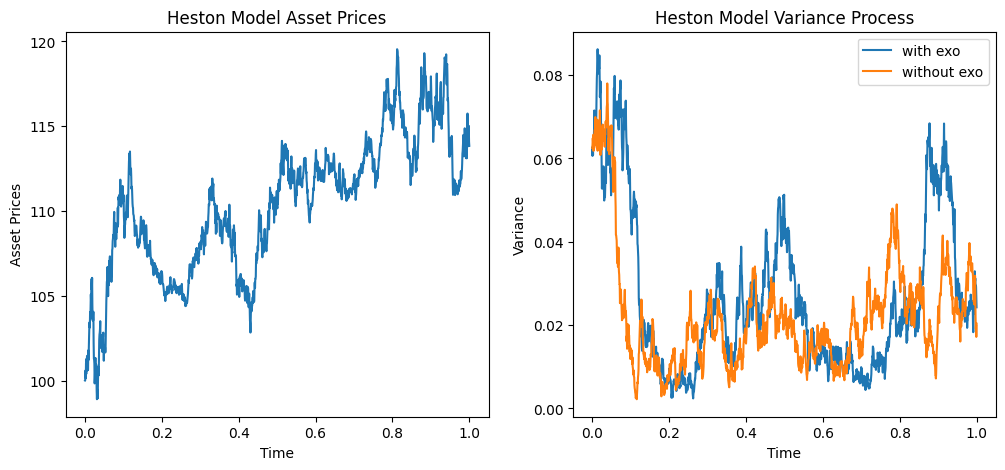

In [264]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time, S_p[0])
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,v_p[0], label='with exo')
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

ax2.plot(time,v_no_x_p, label='without exo')

ax2.legend()

plt.show()

In [238]:
from garch import GARCH
from arch import arch_model


In [239]:
np.mean(S_p)

112.18854012902774

In [240]:
prices_df = pd.DataFrame(S_p, columns = ['Prices'])


ValueError: Shape of passed values is (1, 1513), indices imply (1, 1)

In [241]:
prices_df['returns'] = prices_df['Prices'].pct_change()
prices_df['log_returns'] = np.log(prices_df['Prices'] /prices_df['Prices'].shift(1))

In [242]:
prices_df = prices_df[1:]

In [243]:
prices_df

,Prices,returns,log_returns
2,100.793357,0.003586,0.003580
3,100.514020,-0.002771,-0.002775
4,100.896466,0.003805,0.003798
5,99.922165,-0.009656,-0.009703
6,100.462027,0.005403,0.005388
...,...,...,...
1508,71.338698,-0.019037,-0.019221
1509,70.773402,-0.007924,-0.007956
1510,71.082114,0.004362,0.004352
1511,70.375677,-0.009938,-0.009988


In [244]:
# Fit using ARCH library, without exogeneous
model = arch_model(100*prices_df['log_returns'], vol='GARCH', mean='zero', p=1, q=1)
garch_fit = model.fit(disp='off')

garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1184.06
Distribution:                  Normal   AIC:                           2374.12
Method:            Maximum Likelihood   BIC:                           2390.08
                                        No. Observations:                 1511
Date:                Fri, Mar 07 2025   Df Residuals:                     1511
Time:                        22:44:17   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.5201e-03  2.324e-03      1.515      0.130 [-1.035e-03,8.075e-03]
alpha[1]       0.0151  6.524e-03      2.320  2.032e-02  [2.351e-03,2.792e-02]
beta[1]        0.9725  1.165e-02     83.443      0.000      [  0.950,  0.995]
=============================================================================

Covariance estimator: robust
"""

In [245]:
random.seed(420)
np.random.seed(420)
exo = 0.01 * np.random.randn(N, 1)

In [246]:
garch_with_sentiment = GARCH(p=1, q=1, z=1, verbose=True)
garch_with_sentiment.train(100*prices_df['log_returns'], x = exo)

garch_with_sentiment.summary()

AssertionError: Length of y and x are not equal.

In [219]:
info_matrix = garch_with_sentiment.information_matrix
np.linalg.inv(info_matrix).diagonal()

array([1.82978208e-05, 4.95540798e-05, 2.08777151e-04, 3.71546099e+02])

In [122]:
prices_df

,Prices,returns,log_returns
1,101.061753,0.010618,0.010562
2,101.977255,0.009059,0.009018
3,101.074066,-0.008857,-0.008896
4,102.286712,0.011998,0.011926
5,99.112675,-0.031031,-0.031522
...,...,...,...
248,29.405478,0.018074,0.017913
249,29.143106,-0.008923,-0.008963
250,29.158024,0.000512,0.000512
251,28.948963,-0.007170,-0.007196


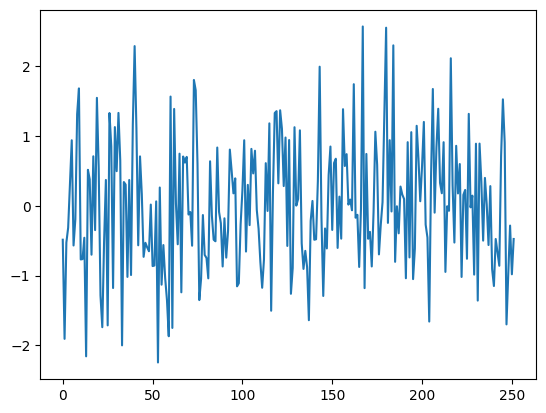

In [125]:
plt.plot(exo)